# Mainly for model training

Depending on the size of your training set, you will need an [inference notebook](https://www.kaggle.com/code/regisvargas/inference-jane-street-a-beginner-s-notebook).

In [1]:
import pandas as pd
# Initialize a list to hold samples from each file
samples = []
# Load a sample from each file
for i in range(10):
    file_path = f"./datas/train.parquet/partition_id={i}/part-0.parquet"
    chunk = pd.read_parquet(file_path)
    
    # Take a sample of the data (adjust sample size as needed)
    sample_chunk = chunk.sample(n=500000, random_state=42)  # For example, 100 rows
    samples.append(sample_chunk)
# Concatenate all samples into one DataFrame if needed
sample_df = pd.concat(samples, ignore_index=True)


In [2]:
sample_df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,85,288,38,3.119714,NaN,NaN,NaN,NaN,NaN,0.188973,...,-0.191460,0.386567,-0.180631,-0.394700,0.212311,1.695289,-0.002445,-0.041428,0.147673,0.352121
1,83,69,0,2.372535,NaN,NaN,NaN,NaN,NaN,-0.249393,...,-0.304067,2.162238,0.687817,0.344059,2.191972,0.183375,0.511344,1.261587,-0.337162,0.283835
2,82,199,16,1.943764,NaN,NaN,NaN,NaN,NaN,-0.034782,...,-0.174753,-0.093317,-0.030093,-0.060351,-0.016916,0.141347,0.084314,0.035796,0.130798,0.339303
3,0,779,9,2.285698,NaN,NaN,NaN,NaN,NaN,-0.200830,...,-0.264010,-0.010857,-0.047279,0.000333,0.223133,0.273011,0.259631,0.265585,0.200747,-0.067575
4,169,178,7,1.789037,NaN,NaN,NaN,NaN,NaN,0.695718,...,-0.256375,-0.107448,-0.852934,-0.150064,-0.000850,-0.035807,-0.328767,0.106589,0.703084,-0.247847


# Prepare data

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
# Separate features and responders
features = sample_df.filter(regex='^feature_')
responders = sample_df.filter(regex='^responder_')
weights = sample_df['weight']
# Convert to numpy arrays for TensorFlow
X = features.values  # Features for input
#y = responders.values  # Responders for output
# Assuming you have a DataFrame `y_train` with all responders
y = responders[['responder_6']].values  # Keep only responder_6
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

In [14]:
Is_keras = True

# XGBoost

See [Feature engineering, xgboost](https://www.kaggle.com/code/dlarionov/feature-engineering-xgboost#Part-2,-xgboost) for details.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

In [6]:
# Define a learning rate schedule
def learning_rate_scheduler_xgb(epoch):
    initial_rate = 0.3
    decay_rate = 0.999
    return initial_rate * (decay_rate ** (np.log(epoch)))

In [7]:
from xgboost import XGBRegressor
# Create an XGBoost model
model_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=learning_rate_scheduler_xgb,
    max_depth=8,
    random_state=42
)
# Fit the model with sample weights and validation dataset
model_xgb.fit(
    X_train,
    y_train,
    sample_weight=weights_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    sample_weight_eval_set=[weights_train, weights_val],
    eval_metric='rmse',
    early_stopping_rounds=10,
    verbose=True
)


ModuleNotFoundError: No module named 'xgboost'

# Build the Autoencoder Model

Gradient Centralization for Better Training Performance

See https://keras.io/examples/vision/gradient_centralization/ for details. 

In [15]:
from keras.optimizers import RMSprop
class GCRMSprop(RMSprop):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.
        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= ops.mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)
        return grads
optimizer = GCRMSprop(learning_rate=1e-4)

In [16]:
from tensorflow.keras.regularizers import l2
# Define the number of input and output nodes
input_dim = X.shape[1]  # Number of features (79)
output_dim = y.shape[1]  # Number of responders (9)
# Define the model
model = models.Sequential([
    layers.Input(shape=(input_dim,)), # Input layer
    layers.LayerNormalization(),
   # layers.BatchNormalization(),
  #  layers.Dense(128, activation='relu'),
  #  layers.Dropout(0.2),
    layers.Dense(64, activation='linear'),  # Encoder
    layers.Dense(32, activation='linear'),  # Bottleneck layer (compression)
    layers.Dense(64, activation='linear'),  # Decoder
#    layers.Dense(128, activation='relu'), 
 #   layers.Dropout(0.2),
    layers.Dense(output_dim, activation='linear', kernel_regularizer=l2(0.001))  # Output layer for responders
])
model.compile(optimizer="adam", loss='mse')

# Train Autoencoder Model

In [17]:
from tensorflow.keras.callbacks import LearningRateScheduler
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr
lr_scheduler = LearningRateScheduler(step_decay)

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,            # Number of epochs to wait for improvement
    min_delta=0.00001,       # Minimum change to qualify as an improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

if Is_keras:
    history = model.fit(
        X, y,
        epochs=50,
        verbose=0,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping,reduce_lr]
    )

In [20]:
if Is_keras:
    model.save("./models/model.keras")

Keys in history.history: dict_keys(['loss', 'val_loss', 'learning_rate'])


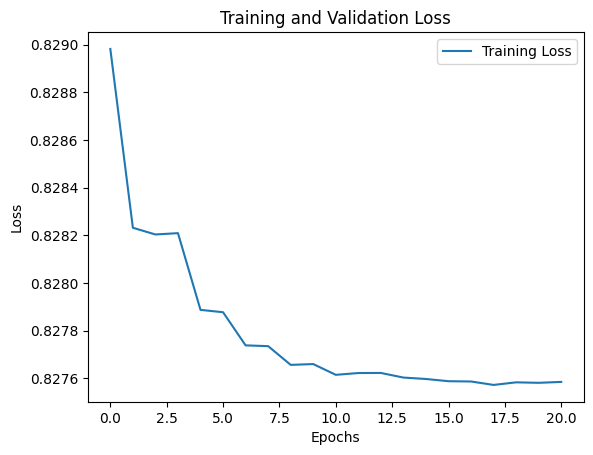

In [29]:
import matplotlib.pyplot as plt
print("Keys in history.history:", history.history.keys())

plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Submission

See [Jane Street RMF Demo Submission](https://www.kaggle.com/code/ryanholbrook/jane-street-rmf-demo-submission) for details.

Depending on the size of your training set, you will need an [inference notebook](https://www.kaggle.com/code/regisvargas/inference-jane-street-a-beginner-s-notebook).

In [21]:
import os
import polars as pl
import kaggle_evaluation.jane_street_inference_server

In [22]:
import polars as pl
import numpy as np
# Assuming `model` is your trained model
# Assuming features required by the model are named 'feature_00', 'feature_01', etc.
def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
    """Make a prediction."""
    global lags_
    if lags is not None:
        lags_ = lags
    # Extract the features for the model input
    feature_columns = [col for col in test.columns if col.startswith("feature_")]
    features = test.select(feature_columns).to_numpy()  # Convert to numpy array for model input
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    # Generate predictions using the model
    #model_predictions = model.predict(features)
    if Is_keras:
        responder_6_predictions = model.predict(features)[:,0]
    else:
        responder_6_predictions = model_xgb.predict(features)
   # print(responder_6_predictions)    
    #responder_6_predictions = model_predictions[:, 6]  # Assuming responder_6 is at index 6
    # Create a new Polars DataFrame with row_id and responder_6 predictions
    predictions = test.select("row_id").with_columns(
        pl.Series("responder_6", responder_6_predictions)
    )
    print(predictions)
    # Ensure the output format and length requirements
    if isinstance(predictions, pl.DataFrame):
        assert predictions.columns == ['row_id', 'responder_6']
    elif isinstance(predictions, pd.DataFrame):
        assert (predictions.columns == ['row_id', 'responder_6']).all()
    else:
        raise TypeError('The predict function must return a DataFrame')
    
    assert len(predictions) == len(test)
    return predictions

In [25]:
inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            './datas/test.parquet',
            './datas/lags.parquet',
        )
    )

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
shape: (39, 2)
┌────────┬─────────────┐
│ row_id ┆ responder_6 │
│ ---    ┆ ---         │
│ i64    ┆ f32         │
╞════════╪═════════════╡
│ 0      ┆ -0.020733   │
│ 1      ┆ -0.020733   │
│ 2      ┆ -0.020733   │
│ 3      ┆ -0.020733   │
│ 4      ┆ -0.020733   │
│ …      ┆ …           │
│ 34     ┆ -0.020733   │
│ 35     ┆ -0.020733   │
│ 36     ┆ -0.020733   │
│ 37     ┆ -0.020733   │
│ 38     ┆ -0.020733   │
└────────┴─────────────┘
